In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

from IPython.display import display, Markdown
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u

from scipy import stats, integrate
from scipy.stats import binom
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
import tensorflow as tf

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [5]:

# previously shared in draft paper
# predictions_loc = 'results/temp/decals_n2_allq_m0_all.csv'
# eval_loc = 'results/temp/decals_n2_allq_m0_eval_shards/eval_df.csv'

# with overzealous cleaning
eval_loc = 'results/decals_dr_full_eval_df.csv'
eval_df = pd.read_csv(eval_loc)
eval_df['local_png_loc'] = eval_df['local_png_loc'].apply(lambda x: x.replace('/data/phys-zooniverse/chri5177', '/media/walml/beta/decals'))
# eval_df doesn't include total-votes, add it
for question in schema.questions:
    eval_df[question.text + '_total-votes'] = np.array([eval_df[answer.text].values for answer in question.answers]).sum(axis=0)

# one model
# predictions_loc = 'results/decals_dr_full_m0_eval_predictions.csv'  # .1-20
# predictions = pd.read_csv(predictions_loc)
# samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])

# several models (ensemble)
samples = []
predictions_locs = [f'results/decals_dr_full_m{n}_eval_predictions.csv' for n in range(3)]  # 0, 1, 2
for predictions_loc in predictions_locs:
    predictions = pd.read_csv(predictions_loc)
    # filter to eval
    eval_predictions = predictions[predictions['iauname'].isin(eval_df['id_str'])]
    print(len(eval_predictions))
    model_samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
    samples.append(model_samples)
samples = np.concatenate(samples, axis=2)  # must be same iaunames, sorted

print(samples.shape)



49700
49700
49700
(49700, 34, 15)


In [6]:
is_retired = eval_predictions['smooth-or-featured_total-votes'] > 34
retired = eval_predictions[is_retired]
retired['file_loc'] = retired['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
retired_samples = samples[is_retired]


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
predicted_fractions = dirichlet_stats.dirichlet_prob_of_answers(retired_samples, schema, temperature=None)

In [8]:
def filter_to_sensible(label_df, predictions, question):
#     if prev_a is not None:
#         prev_q = prev_a.question
#         prev_q_cols = [answer.text + '_fraction' for answer in prev_q.answers]
#         is_sensible = (label_df[prev_a.text + '_fraction'] / label_df[prev_q_cols].sum(axis=1)) > 0.5
#         valid_labels, valid_predictions = label_df[is_sensible], predicted_fractions[is_sensible]
#     else:
#         valid_labels, valid_predictions = label_df, predicted_fractions
    retirement = 1
    samples = np.expand_dims(predictions, axis=-1)
    expected_votes = acquisition_utils.get_expected_votes_human(label_df, question, retirement, schema, round_votes=False)
    if not isinstance(expected_votes, np.ndarray):
        expected_votes = expected_votes.numpy()  # hack, should fix properly...
#     print(expected_votes)
    is_sensible = expected_votes > 0.5
    valid_labels, valid_predictions = label_df[is_sensible], predictions[is_sensible]
    return valid_labels, valid_predictions


In [11]:
def get_binary_responses(question, label_df, predicted_fractions):
    # previous question should be valid
    valid_labels, valid_predictions = filter_to_sensible(label_df, predicted_fractions, question)
    cols = [answer.text + '_fraction' for answer in question.answers]
    # most likely answer, might be less than .5 though
    y_true = np.argmax(valid_labels[cols].values, axis=1)
    y_pred = np.argmax(valid_predictions[:, question.start_index:question.end_index+1], axis=1)
    return y_true, y_pred

def print_metrics(question, label_df, predicted_fractions):
    y_true, y_pred = get_binary_responses(question, label_df, predicted_fractions)
#     print(pd.value_counts(y_pred))
#     average = 'micro'
    average = 'weighted'
    
    # human
#     print('Acc: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} <- {}'.format(
#         sklearn.metrics.accuracy_score(y_true, y_pred),
#         sklearn.metrics.precision_score(y_true, y_pred, average=average),
#         sklearn.metrics.recall_score(y_true, y_pred, average=average),
#         sklearn.metrics.f1_score(y_true, y_pred, average=average),
#         question.text
#     ))
    # latex
    print('{} & {} & {:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(
        question.text.replace('-', ' ').replace('_', ' ').title(),
        len(y_true),
        sklearn.metrics.accuracy_score(y_true, y_pred),
        sklearn.metrics.precision_score(y_true, y_pred, average=average),
        sklearn.metrics.recall_score(y_true, y_pred, average=average),
        sklearn.metrics.f1_score(y_true, y_pred, average=average)
))

    
def show_confusion_matrix(question, label_df, predicted_fractions):
    y_true, y_pred = get_binary_responses(question, label_df, predicted_fractions)
    
    labels = range(len(question.answers))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    ticklabels = [get_label(a.text, question) for a in question.answers]
    # manual tweaks
    for n in range(len(ticklabels)):
        if ticklabels[n] == 'Featured Or Disk':
            ticklabels[n] = 'Featured/Disk'
        elif ticklabels[n] == 'Cigar Shaped':
            ticklabels[n] = 'Cigar'
        elif ticklabels[n] == 'More Than 4':
            ticklabels[n] = '>4'
        elif ticklabels[n] == 'Minor Disturbance':
            ticklabels[n] = 'Minor Disturb.'
        elif ticklabels[n] == 'Major Disturbance':
            ticklabels[n] = 'Major Disturb.'
            
    fig, ax = plt.subplots()
    ax.set_title(clean_text(question.text))

    return sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='d',
        xticklabels=ticklabels,
        yticklabels=ticklabels,
        cbar=False,
#         annot_kws={"size": 14},
        ax=ax,
        square=True,
        robust=True
    )


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


2859

In [10]:
retirement = 1  # assumed number of votes at top question
# votes for specific question, given fraction predictions and retirement (=1)
expected_votes = acquisition_utils.get_expected_votes_human(retired, question, retirement, schema, round_votes=False)  

In [14]:
for question in schema.questions:
    print_metrics(question, retired, predicted_fractions)

Smooth Or Featured & 11346 & 0.9352 & 0.9363 & 0.9352 & 0.9356 \\
Disk Edge On & 3803 & 0.9871 & 0.9871 & 0.9871 & 0.9871 \\
Has Spiral Arms & 2859 & 0.9349 & 0.9364 & 0.9349 & 0.9356 \\
Bar & 2859 & 0.8185 & 0.8095 & 0.8185 & 0.8110 \\
Bulge Size & 2859 & 0.8419 & 0.8405 & 0.8419 & 0.8409 \\
How Rounded & 6805 & 0.9314 & 0.9313 & 0.9314 & 0.9313 \\
Edge On Bulge & 506 & 0.9111 & 0.9134 & 0.9111 & 0.8996 \\
Spiral Winding & 1997 & 0.7832 & 0.8041 & 0.7832 & 0.7874 \\
Spiral Arm Count & 1997 & 0.7742 & 0.7555 & 0.7742 & 0.7560 \\
Merging & 11346 & 0.8798 & 0.8672 & 0.8798 & 0.8511 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# y_true = [0, 1, 2, 3, 4]
# y_pred = [0, 0, 0, 0, 0]
# labels=y_true
# cm = confusion_matrix(y_true, y_pred, labels=labels)
# cm

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [50]:
def get_big_cm(label_df, predicted_fractions, schema):
    y_pred = []
    y_true = []
    for question in schema.questions:
        y_true_q, y_pred_q = get_binary_responses(question, label_df, predicted_fractions)
        print(len(y_true_q))
        y_pred_q += question.start_index
        y_true_q += question.start_index
#         valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, schema.get_question('has-spiral-arms'))
#         for galaxy_n in len(valid_predictions):
#             question_answer = question.start_index + np.argmax(valid_predictions[galaxy_n, indices])
#             y_pred.append(galaxy)
#             y_true = valid_labels.iloc[galaxy_n][question.]
        y_pred += list(y_pred_q)
        y_true += list(y_true_q)
        
    return np.array(y_true), np.array(y_pred)

In [51]:
y_true, y_pred = get_big_cm(retired, predicted_fractions, schema)

11346
3803
2859
2859
2859
6805
506
1997
1997
11346


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [52]:
big_cm = confusion_matrix(y_true, y_pred)

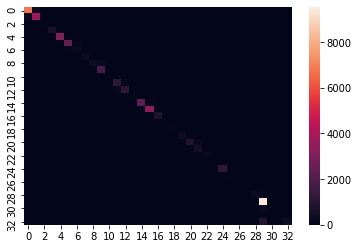

In [54]:
sns.heatmap(big_cm)

In [55]:
feat_labels, feat_predictions = filter_to_sensible(retired, predicted_fractions, schema.get_question('has-spiral-arms'))

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [73]:
def get_vol_vector(labels, questions_to_include):  # all q's must be relevant
    vol_vectors = np.zeros((len(labels), len(questions_to_include)))
    for question_n, question in enumerate(questions_to_include):
        cols = [answer.text + '_fraction' for answer in question.answers]
        question_responses = valid_labels[cols].values
        vol_vectors[:, question_n] = np.argmax(question_responses, axis=1)
    return vol_vectors

In [91]:
def get_ml_vector(preds, questions_to_include):  # all q's must be relevant
    ml_vectors = np.zeros((len(preds), len(questions_to_include)))
    for question_n, question in enumerate(questions_to_include):
        question_responses = preds[:, question.start_index:question.end_index+1]
        ml_vectors[:, question_n] = np.argmax(question_responses, axis=1)
    return ml_vectors

In [108]:
questions_to_include = [
    schema.get_question('bar'),
    schema.get_question('has-spiral-arms'),
    schema.get_question('merging')
]

In [109]:
vol_vectors = get_vol_vector(feat_labels, questions_to_include)

(2859, 3)


In [110]:
vol_vectors.shape

(2859, 3)

In [111]:
# col_indices = [answer.index for question in questions_to_include for answer in question.answers]
# col_indices
# ml_vectors = feat_predictions[:, col_indices]
# ml_vectors.shape

In [112]:
ml_vectors = get_ml_vector(feat_predictions, questions_to_include)
ml_vectors.shape

(2859, 3)

In [113]:
def get_label(text, question):
    return clean_text(text.replace(question.text, '').title())

def clean_text(text):
    return text.replace('-', ' ').replace('_', '').title()

In [149]:
def show_cm(y_true, y_pred, labels, question, title=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    
    ticklabels = [get_label(a.text, question) for a in question.answers]
    # manual tweaks
    for n in range(len(ticklabels)):
        if ticklabels[n] == 'Featured Or Disk':
            ticklabels[n] = 'Featured/Disk'
        elif ticklabels[n] == 'Cigar Shaped':
            ticklabels[n] = 'Cigar'
        elif ticklabels[n] == 'More Than 4':
            ticklabels[n] = '>4'
        elif ticklabels[n] == 'Minor Disturbance':
            ticklabels[n] = 'Minor Disturb.'
        elif ticklabels[n] == 'Major Disturbance':
            ticklabels[n] = 'Major Disturb.'
    
    fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    
    if normalise == 'true':
        fmt = 'd'
    else:
        fmt = None

    return sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='.2g',
        xticklabels=ticklabels,
        yticklabels=ticklabels,
        cbar=False,
#         annot_kws={"size": 14},
        ax=ax,
        square=True,
        robust=True
    )

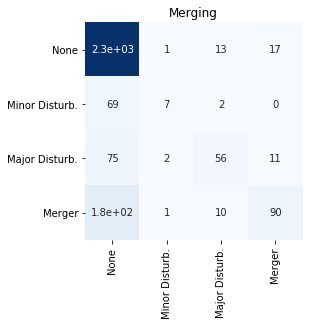

In [141]:
question_n = 2
question = questions_to_include[question_n]
show_cm(vol_vectors[:, question_n], ml_vectors[:, question_n], labels=np.arange(len(question.answers)), question=question)

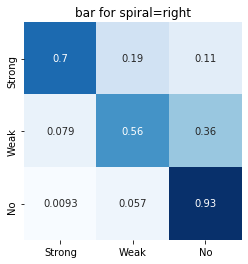

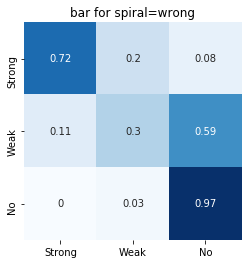

In [153]:
question_c = 1
question_n = 0
question = questions_to_include[question_n]
correct = vol_vectors[:, question_c] == ml_vectors[:, question_c]

title = 'bar for spiral=right'
title_2 = 'bar for spiral=wrong'
normalize = 'true'
show_cm(vol_vectors[correct, question_n], ml_vectors[correct, question_n], labels=np.arange(len(question.answers)), question=question, normalize=normalize, title=title)
show_cm(vol_vectors[~correct, question_n], ml_vectors[~correct, question_n], labels=np.arange(len(question.answers)), question=question, normalize=normalize, title=title_2)

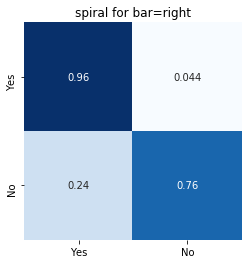

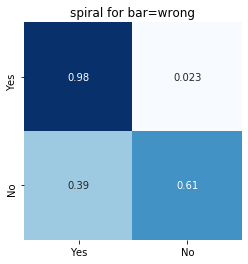

In [154]:
question_c = 0
question_n = 1
question = questions_to_include[question_n]
correct = vol_vectors[:, question_c] == ml_vectors[:, question_c]

title = 'spiral for bar=right'
title_2 = 'spiral for bar=wrong'
normalize = 'true'
show_cm(vol_vectors[correct, question_n], ml_vectors[correct, question_n], labels=np.arange(len(question.answers)), question=question, normalize=normalize, title=title)
show_cm(vol_vectors[~correct, question_n], ml_vectors[~correct, question_n], labels=np.arange(len(question.answers)), question=question, normalize=normalize, title=title_2)

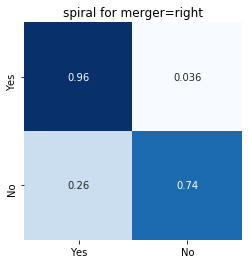

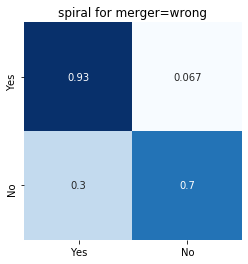

In [155]:
question_c = 2
question_n = 1
question = questions_to_include[question_n]
correct = vol_vectors[:, question_c] == ml_vectors[:, question_c]

title = 'spiral for merger=right'
title_2 = 'spiral for merger=wrong'
normalize = 'true'
show_cm(vol_vectors[correct, question_n], ml_vectors[correct, question_n], labels=np.arange(len(question.answers)), question=question, normalize=normalize, title=title)
show_cm(vol_vectors[~correct, question_n], ml_vectors[~correct, question_n], labels=np.arange(len(question.answers)), question=question, normalize=normalize, title=title_2)

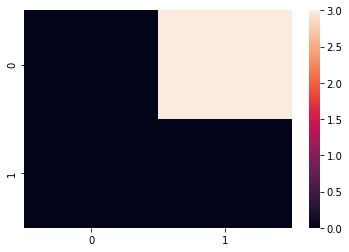

In [147]:
cm = confusion_matrix([0, 0, 0], [1, 1, 1])
sns.heatmap(cm)

if wrong about bars, more likely to think non-spirals are spirals

if wrong about spirals, more likely to think weak bars are not bars


true labels = rows, predicted = columns

In [ ]:
def get_big_cm(label_df, predicted_fractions, schema):
    y_pred = []
    y_true = []
    for question in schema.questions:
        y_true_q, y_pred_q = get_binary_responses(question, label_df, predicted_fractions)
        print(len(y_true_q))
        y_pred_q += question.start_index
        y_true_q += question.start_index
#         valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, schema.get_question('has-spiral-arms'))
#         for galaxy_n in len(valid_predictions):
#             question_answer = question.start_index + np.argmax(valid_predictions[galaxy_n, indices])
#             y_pred.append(galaxy)
#             y_true = valid_labels.iloc[galaxy_n][question.]
        y_pred += list(y_pred_q)
        y_true += list(y_true_q)
        
    return np.array(y_true), np.array(y_pred)